# Data Acquisition and Cleaning
### Data acquisition
run the following to get the data. inside a bunch of nested directories there will be 'rois_ho'. make that directory top level, for the rest of the code to work.

python download_abide_preproc.py -d rois_ho -p ccs -s filt_global -o .

Some information:
parameters of the data-getting call: [here](https://raw.githubusercontent.com/preprocessed-connectomes-project/abide/master/download_abide_preproc_guide.txt)

I selected parameters based on what seemed would make the data simpler. Hoping that any algorithm or code we write would work on any derivitive of this function, so we can test on all of them and compare results.

In [1]:
import numpy as np
# dope plotting functions
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
# random sample
data_sample = np.loadtxt('rois_ho/Caltech_0051460_rois_ho.1D')
# time is along x axis
data_sample = data_sample.T
# pearson correlation
correl = np.corrcoef(data_sample)
data = [
    go.Heatmap(
        z = correl.T - np.eye(correl.shape[0])
    )
]
layout = go.Layout(
        yaxis=dict(autorange='reversed')
)
fig = go.Figure(data=data, layout=layout)
fig['layout'].update(height = 800, width = 800, autosize=False)
iplot(fig)

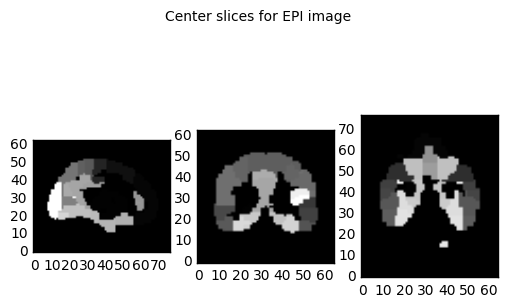

In [2]:
# Show the Harvard Oxford atlas
import nibabel as nib
img = nib.load('ho_mask_pad.nii')
import matplotlib.pyplot as plt
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

test_img = img.get_data()
slice_0 = test_img[26, :, :]
slice_1 = test_img[:, 30, :]
slice_2 = test_img[:, :, 16]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")
plt.show()

In [3]:
# Get the 'middle' of each region
from skimage.measure import regionprops
centers = np.array(map(lambda x: np.mean(x["coords"], axis=0), regionprops(test_img)))
trace1 = go.Scatter3d(
    x = centers[:, 0], 
    y = centers[:, 1],
    z = centers[:, 2],
    mode='markers',
    marker=dict(
        size=12,
        color="blue",   # choose a colorscale
        opacity=0.3
    )
)
data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)


In [4]:
# heatmap to show how means differ
data = [
    go.Heatmap(
        z = data_sample
    )
]
iplot(data)

In [5]:
# more informative if we mean center
data_sample = data_sample - np.mean(data_sample, axis=1).reshape(-1, 1)
data = [
    go.Heatmap(
        z = data_sample
    )
]
iplot(data)

In [6]:
# how do projections onto top 3 princ. directions look over time
U, S, Vt = np.linalg.svd(data_sample,full_matrices=False)
norm = np.diag(1.0 / S[:3])
data_transform = norm.dot((np.dot(U[:, :3].T, data_sample) * np.sqrt(data_sample.shape[0])))
data = [
    go.Heatmap(
        z = data_transform
    )
]
iplot(data)

In [7]:
# better way to represent above i think
# blue is beginning of time, red is end.
from plotly.graph_objs import ColorBar
trace = go.Scatter3d(
    x=data_transform[0], y=data_transform[1], z=data_transform[2],
    marker=dict(
        size=4,
        cmax=data_transform.shape[1] - 1,
        cmin=0,
        color= range(data_transform.shape[1]),
        colorbar=ColorBar(
            title='Colorbar'
        ),
        colorscale='Jet'
    ),
    line=dict(
        width=3,
        cmax=data_transform.shape[1] - 1,
        cmin=0,
        color= range(data_transform.shape[1]),
        colorscale='Jet'
    )
)

data = [trace]

fig = dict(data=data, layout=layout)

iplot(fig)


In [8]:
# throw some k means in there because why not
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(data_transform.T)
from plotly.graph_objs import ColorBar
trace = go.Scatter3d(
    x=data_transform[0], y=data_transform[1], z=data_transform[2],
    mode='markers',
    marker=dict(
        size=4,
        cmax=4,
        cmin=0,
        color= kmeans.labels_,
        colorbar=ColorBar(
            title='Colorbar'
        ),
        colorscale='Jet'
    )
)

data = [trace]

fig = dict(data=data)
iplot(fig)


In [9]:
# extracting the metadata
import csv
patient_list = []
with open('Phenotypic_V1_0b_preprocessed1.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        patient_list.append(row)

file_names = map(lambda x: patient_list[x]["FILE_ID"], range(len(patient_list)))
diagnostic_gp = map(lambda x: patient_list[x]["DX_GROUP"], range(len(patient_list)))
diagnostic_gp = np.array(map(int, diagnostic_gp))
print np.sum(diagnostic_gp == 2), "controls,", np.sum(diagnostic_gp == 1), "with autism"

573 controls, 539 with autism


In [10]:
def scatter(x, y):
    # Create a trace
    print len(x)
    trace = go.Scatter(
        x = x,
        y = y,
        mode = 'markers',
        text=map(str, np.arange(111))
    )

    data = [trace]

    # Plot and embed in ipython notebook!
    iplot(data)

In [11]:
# simple block clustering algorithm
old_val = np.sum(np.sum(np.abs(np.roll(correl, 1) - correl), axis=1))
print old_val
for k in range(1, 20):    
    for i in range(1000):
        one = np.random.randint(111)
        dist = np.random.randint(k) + 1
        two = one + np.random.randint(3*dist)
        B = np.roll(data_sample, -1 * two, axis=1)[:, :dist]
        new_sample = np.column_stack([B, np.roll(data_sample, -1 * one, axis=1)[:, dist:]])
        correl = np.corrcoef(new_sample)
        val = np.sum(np.sum(np.abs(np.roll(correl, 1) - correl), axis=1))
        if val < old_val or np.random.random() < .0001:
            old_val = val
            data_sample = new_sample
    print old_val

2729.0807653
2502.06885813
2449.86029014
2434.85527124
2432.4054498
2430.25266263
2430.23125364
2430.23125364
2427.02867912
2469.28210579
2463.77363336
2463.48589174
2461.10036841
2457.84394354
2457.45000499
2456.367717
2454.65746738
2454.13275364
2454.13275364
2448.79774069


In [12]:
correl = np.corrcoef(data_sample)
data = [
    go.Heatmap(
        z = correl.T - np.eye(correl.shape[0])
    )
]
layout = go.Layout(
        yaxis=dict(autorange='reversed')
)
fig = go.Figure(data=data, layout=layout)
fig['layout'].update(height = 800, width = 800, autosize=False)
iplot(fig)

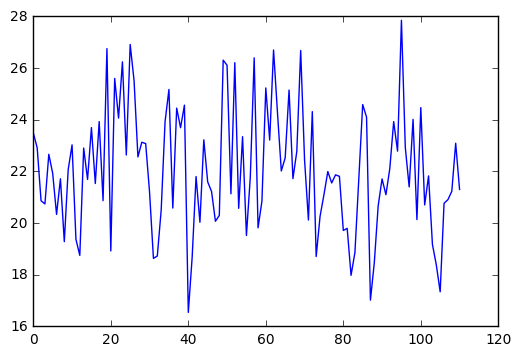

In [14]:
#show where edges are
correl = np.corrcoef(data_sample)
plt.plot(np.sum(np.abs(np.roll(correl, 1) - correl), axis=1))
plt.show()